
# ENSO regularity analysis with xentropy

This notebook demonstrates how to calculate ENSO regularity using the xentropy package.
We use sample entropy (SampEn) to quantify the predictability of the Niño3.4 index in observations like Fig. 2a in Stuecker et al. (2025).

Stuecker, M. F., Zhao, S., Timmermann, A., Ghosh, R., Semmler, T., Lee, S.-S., et al. (2025). Global climate mode resonance due to rapidly intensifying El Niño–Southern Oscillation. **Nature Communications**. in revision. 


In [1]:
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

# ignore warnings
import os
import sys

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr

import urllib.request

import matplotlib
import matplotlib.pyplot as plt

from xentropy import xentropy


Text(0, 0.5, 'SST anomaly (°C)')

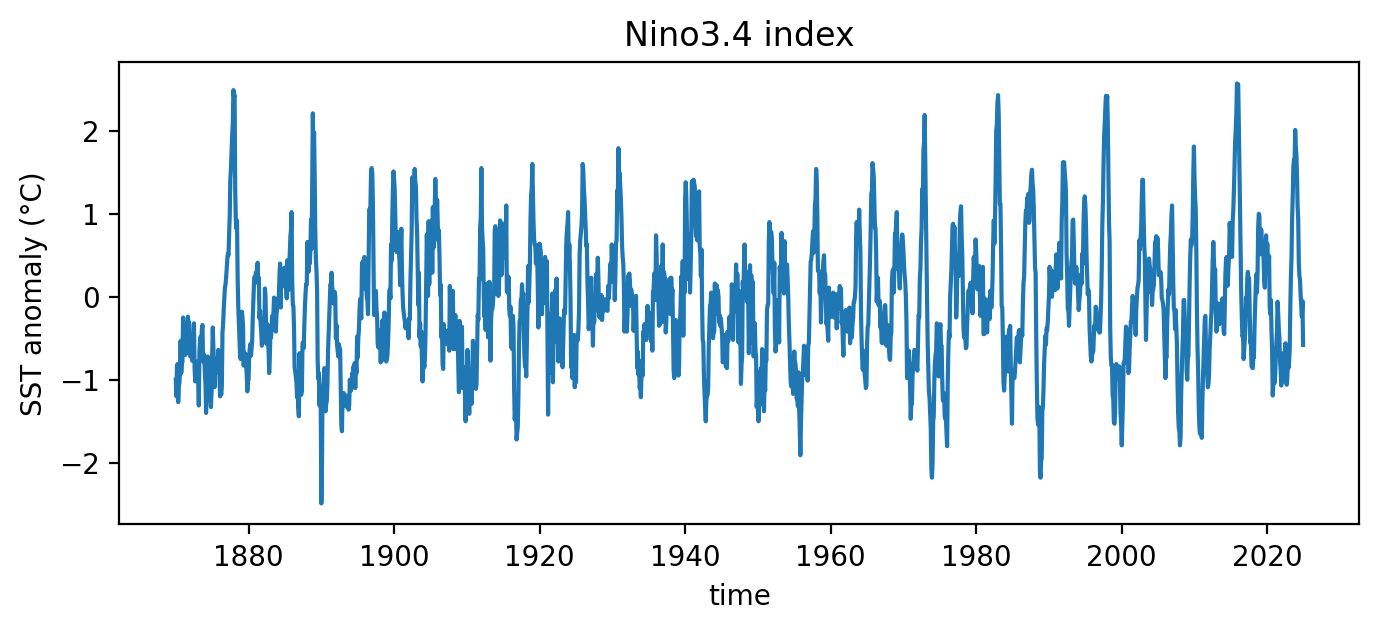

In [2]:
# Load ENSO time series from NOAA PSL

url_data = "https://psl.noaa.gov/data/timeseries/month/data/nino34.long.anom.nc"
urllib.request.urlretrieve(url_data, "nino34.nc")

ds = xr.open_dataset("nino34.nc")['value'].sel(time=slice('1870-01', '2024-12'))

ds.plot(figsize=(8, 3) )
plt.title('Nino3.4 index')
plt.ylabel('SST anomaly (°C)')


In [3]:
## moving 21-yr 

def rolling_by_year(ds, rolling_years=11):
    # # Check if time is sorted
    # np_dates = np.array([np.datetime64(_convert_date(date)) for date in ds.time.values])
    # assert np.all(np.diff(np_dates) > np.timedelta64(0)), "Time dimension must be sorted in ascending order."

    # Check if data is monthly
    assert len(ds.time) % 12 == 0, "Data must have 12 time points per year."

    years = ds['time.year'][::12].values
    segment = ds.isel(time=slice(0, rolling_years * 12)).time.values
    slices = []
    succ_time = []

    for it in range(len(years) - rolling_years + 1):
        sel_ds = ds.isel(time=slice(it * 12, it * 12 + rolling_years * 12)).copy()
        tim_mid = years[it] + (rolling_years - 1) / 2

        sel_ds['time'] = segment
        slices.append(sel_ds)
        succ_time.append(tim_mid)

    xr_out = xr.concat(slices, dim='center_year')
    xr_out['center_year'] = succ_time

    return xr_out.transpose('time', 'center_year', ...)

mv21_ds = rolling_by_year(ds, rolling_years=21)
print(mv21_ds)

<xarray.DataArray 'value' (time: 252, center_year: 135)> Size: 136kB
array([[-1.  , -0.25, -0.72, ..., -0.14,  0.98,  0.26],
       [-1.2 , -0.58, -0.62, ...,  0.  ,  0.64,  0.17],
       [-0.83, -0.43, -0.5 , ...,  0.11,  0.48, -0.1 ],
       ...,
       [-1.26, -0.03, -1.54, ..., -0.99,  1.59, -0.24],
       [-1.07,  0.06, -1.62, ..., -0.76,  2.01, -0.05],
       [-0.68,  0.01, -1.18, ..., -0.86,  1.81, -0.58]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2kB 1870-01-01 1870-02-01 ... 1890-12-01
  * center_year  (center_year) float64 1kB 1.88e+03 1.881e+03 ... 2.014e+03
Attributes:
    description5:    units=degC
    description4:   https://psl.noaa.gov/data/timeseries/month/Nino34/
    description3:    Anomaly from 1981-2010
    description2:   HadISST 
    description1:   5N-5S 170W-120W 
    long_name:       NINA34
    title:           NINA34
    nextra:        7
    Last_year:     2025
    First_year:    1870
    units:           
    name:          descrip

In [4]:
## calcuale sample entropy (SampEn) over dim='time'

xen = xentropy(dim='time')

mv21_sampen = xen.SampEn(mv21_ds)
print( mv21_sampen )

<xarray.DataArray 'value' (center_year: 135)> Size: 1kB
array([1.01751226, 0.97523904, 0.97512122, 0.8954876 , 0.87881562,
       0.88218632, 0.87927827, 0.91496535, 0.98433434, 1.05037385,
       1.04641256, 1.10456216, 1.04565642, 1.0363991 , 0.98435564,
       0.99053378, 1.00063188, 0.98855983, 1.01283421, 1.06967718,
       1.07788616, 1.10995127, 1.12124793, 1.20916762, 1.27637992,
       1.41239311, 1.34043814, 1.30903588, 1.3546795 , 1.35812348,
       1.37619893, 1.36811204, 1.444228  , 1.4755925 , 1.50342741,
       1.4638526 , 1.48599372, 1.48136273, 1.48063178, 1.33099572,
       1.35231849, 1.35520377, 1.47881773, 1.41343467, 1.33893034,
       1.36560772, 1.39072896, 1.43410221, 1.41722466, 1.42773155,
       1.43508453, 1.33365063, 1.35424414, 1.23081771, 1.25959671,
       1.25057956, 1.2009683 , 1.2761945 , 1.22901379, 1.33066267,
       1.36639321, 1.37169556, 1.43752355, 1.52167316, 1.53916872,
       1.55112276, 1.53242981, 1.55021855, 1.48040765, 1.57264007,
      

Text(0.5, 0, 'Center year of moving 21-yr window')

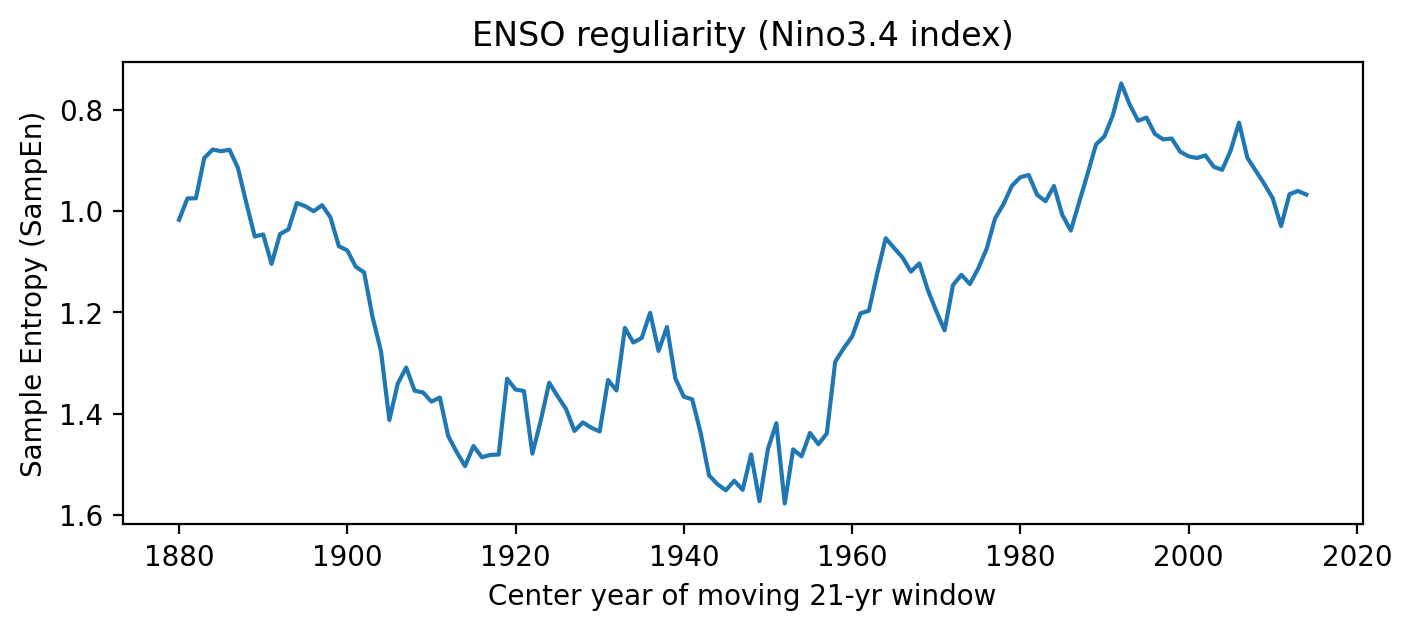

In [5]:
# plot moving 21-yr SampEn

mv21_sampen.plot(figsize=(8, 3) )
plt.gca().invert_yaxis()
plt.title('ENSO reguliarity (Nino3.4 index)')
plt.ylabel('Sample Entropy (SampEn)')
plt.xlabel('Center year of moving 21-yr window')
